# Single Shooting

In [12]:
import casadi as cs
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Das Single Shooting Verfahren (Einfachschießverfahren) basiert auf dem Prinzip der sequentiellen Simulation und Optimierung. Das System wird zunächst in Abhängigkeit der unbekannten Steuerfolge $\{\boldsymbol{u}_{k}\}_{k=0}^{N-1} = \{\boldsymbol{u}_{1},\boldsymbol{u}_{2},\dots,\boldsymbol{u}_{N-1} \}$ simuliert
\begin{align}
\boldsymbol{x}_{1} &= \boldsymbol{f}(\boldsymbol{x}_{0},\boldsymbol{u}_{0})\\
\boldsymbol{x}_{2} &= \boldsymbol{f}(\boldsymbol{x}_{1},\boldsymbol{u}_{1}) =  \boldsymbol{f}(\boldsymbol{f}(\boldsymbol{x}_{0},\boldsymbol{u}_{0}),\boldsymbol{u}_{1})\\
\boldsymbol{x}_{3} &= \boldsymbol{f}(\boldsymbol{x}_{2},\boldsymbol{u}_{2}) =  \boldsymbol{f}(\boldsymbol{f}(\boldsymbol{f}(\boldsymbol{x}_{0},\boldsymbol{u}_{0}),\boldsymbol{u}_{1}),\boldsymbol{u}_{2}) \\
\vdots &= \vdots
\end{align}

Lade bereits identifiziertes Modell

In [13]:
dyn_model = pkl.load(open('dyn_model.pkl','rb') )

f_model = dyn_model['f_model']
A_opt = dyn_model['A_opt']
B_opt = dyn_model['B_opt']
C_opt = dyn_model['C_opt']

Simuliere identifiziertes Modell in Abhängigkeit einer unbekannten Steuerfolge

In [16]:
opti = cs.Opti()
N = 10

U = opti.variable(N-1,1)

x_est = [np.array([[0],[0]])]
y_est = []

for k in range(U.shape[0]):
    pred = f_model(u=U[k],x=x_est[-1],A=A_opt,B=B_opt,C=C_opt)
    
    x_est.append(pred['x_new'])
    y_est.append(pred['y'])


# Listen in Arrays konvertieren
y_est = cs.vcat(y_est)
x_est = cs.vcat(x_est)


y_est[-1].shape

(1, 1)

Als Referenztrajektorie wird exemplarisch eine langsame Sinusschwingung gewählt

(9, 1)

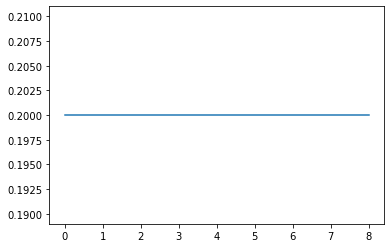

In [4]:
#y_ref = np.sin(1/300 * 2* np.pi *np.arange(0,N-1,1))
#y_ref = y_ref.reshape((-1,1))

y_ref =[[np.random.randint(-20,20)/10]*l[0] for l in np.random.randint(20,50,(10,1))]
y_ref = np.hstack(y_ref).reshape(-1,1)[0:N-1,:]
y_ref[0:10,:] = 0.2

plt.plot(y_ref)
y_ref.shape

Die Bewertung der Differenz zwischen Referenztrajektorie und prädizierter Trajektorie erfolgt mittels einer Kostenfunktion

In [5]:
L = cs.sumsqr((y_ref - y_est))

opti.minimize(L)

opti.solver('ipopt')

sol = opti.solve()

U_opt = sol.value(U)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       36

Total number of variables............................:        9
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

Simulate model for optimized input trajectory

In [6]:
x_est = [np.array([[0],[0]])]
y_est = []

for k in range(U_opt.shape[0]):
    pred = f_model(u=U_opt[k],x=x_est[-1],A=A_opt,B=B_opt,C=C_opt)
    
    x_est.append(pred['x_new'])
    y_est.append(pred['y'])
    
y_est = np.vstack(y_est)

Plotte Referenztrajektorie, realisierte optimale Trajektorie und optimierte Stellgrößentrajektorie

array([0.09920638, 0.04911913, 0.07443669, 0.08719734, 0.09362901,
       0.09687073, 0.09850463, 0.09932815, 0.        ])

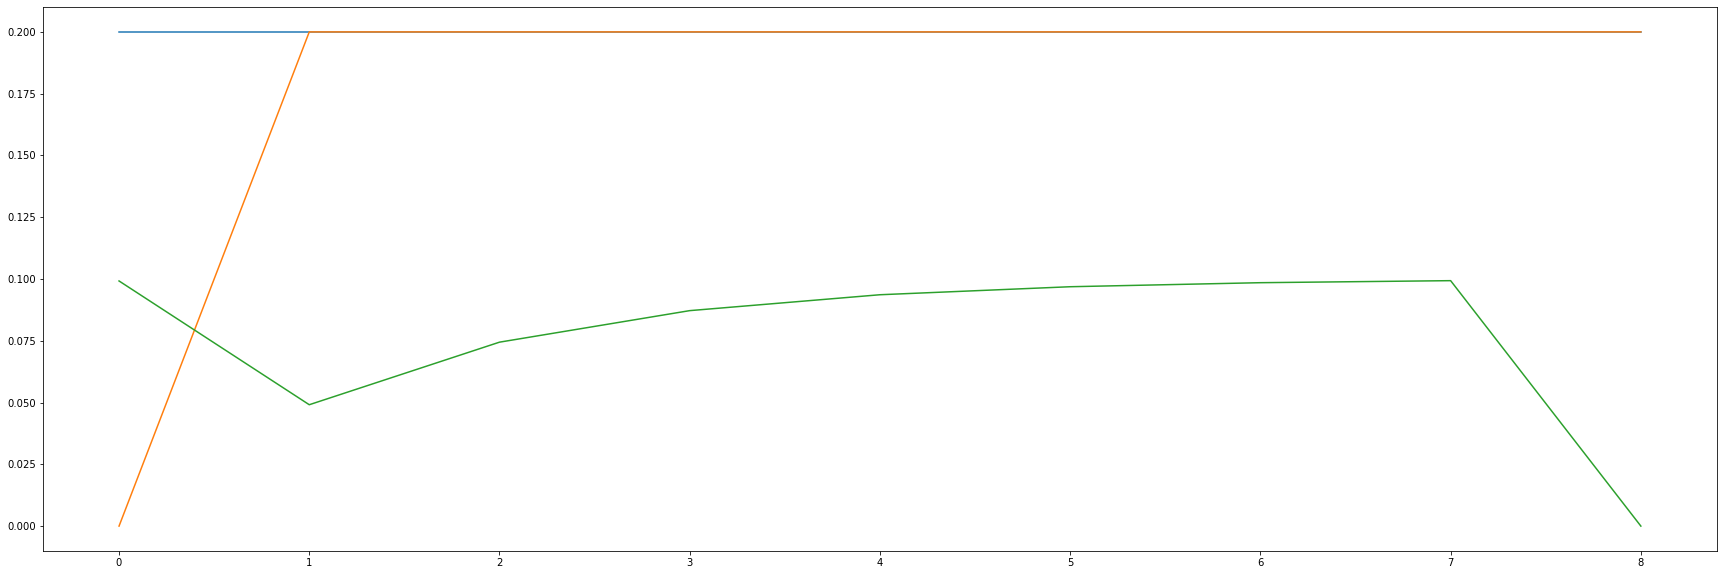

In [11]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches((30,10))
ax.plot(y_ref)
ax.plot(y_est)
ax.plot(U_opt)

Die Lösung des Optimalsteuerungsproblems basiert auf der Annahme, dass jede Stellgrößentrajektorie realisierbar ist. In praktischen Anwendungen existieren allerdings Beschränkungen bezüglich der realisierbaren Stellgrößen und Änderungen der Stellgrößen. Diese können durch Nebenbedingunen berücksichtigt werden:

In [8]:
for k in range(0,N-2):
    #print(k)
    opti.subject_to(cs.fabs(U[k+1] - U[k]) < 0.5)

In [9]:
p_opts = {"expand":False}
s_opts = {"max_iter": 1000}

opti.solver('ipopt',p_opts,s_opts)
#sol = opti.solve()
U_opt = sol.values(U)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       16
Number of nonzeros in Lagrangian Hessian.............:       38

Total number of variables............................:        9
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        8
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        8

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Maximum_Iterations_Exceeded'

In [ ]:
sol = opti.debug.value


In [ ]:
U_opt = sol(U)

In [ ]:
x_est = [np.array([[0],[0]])]
y_est = []

for k in range(U_opt.shape[0]):
    pred = f_model(u=U_opt[k],x=x_est[-1],A=A_opt,B=B_opt,C=C_opt)
    
    x_est.append(pred['x_new'])
    y_est.append(pred['y'])
    
y_est = np.vstack(y_est)

In [ ]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches((30,10))
ax.plot(y_ref)
ax.plot(y_est)
ax.plot(U_opt)

In [17]:
A_opt

array([[ 0.50415383, -0.50517807],
       [ 0.50517017,  0.50474907]])